# Detecting rooftop available surface for installing PV modules in aerial images using Machine Learning

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import torch
from torch.autograd import Variable
from torchvision.transforms.functional import normalize
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset
from train.train import *

from process_data.data_noara_loader import *
from model.unet import *
from loss.loss import *
from process_data.data_loader import *
from hyperparameters.select_param import *
from process_data.import_test import *
from plots import *

%load_ext autoreload
%autoreload 2

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#seed_torch()

# Loading the Data Set
First we load the data set that we will use for training. Each sample is an image with its mask (label). An image is represented as a 3x250x250 array with each of the 3 color chanel being 250x250 pixels. The asssociated mask is a 250x250 array, 

In [3]:
folder_path_train_image = 'data/train/images'
folder_path_train_masks = 'data/train/labels'
folder_path_test_image = 'data/test/images'
folder_path_test_masks = 'data/test/labels'
folder_path_val_image = 'data/val/images'
folder_path_val_masks = 'data/val/labels'

#load dataset
train_set = DataLoaderSegmentation(folder_path_train_image,folder_path_train_masks) # 80%
test_set = DataLoaderSegmentation(folder_path_test_image,folder_path_test_masks,augment=False)# 10%
val_set = DataLoaderSegmentation(folder_path_val_image,folder_path_val_masks,augment=False) # 10%

train_loader = DataLoader(train_set,batch_size=2, shuffle=True ,num_workers=0)
val_loader = DataLoader(val_set,batch_size=2, shuffle=True ,num_workers=0)
test_loader = DataLoader(test_set,batch_size=2, shuffle=True ,num_workers=0)

model = UNet(3,1,False).to(device)
print(len(train_set),len(test_set),len(val_set))
print(len(val_loader),len(val_loader)*2)

244 31 30
15 30


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
nimages = 0
mean = 0.
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print(mean)
print(std)


# Training Loop

In [ ]:
num_epochs = 200
model = UNet(3,1,False).to(device)
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([6]).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trained_model = training_model(train_loader,loss_function,optimizer,model,num_epochs)

In [ ]:
model = trained_model

## Export or Load trained model

In [41]:
torch.save(model.state_dict(), 'model/'+input('Name of the model file:')+".pt")

In [4]:
path = 'model/'+input('Name of the model file:')+".pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Training with adaptative learning rate

In [53]:
num_epochs = 350
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([6]).cuda())
model = UNet(3,1,False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.63, last_epoch=-1, verbose=False)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=0.01, last_epoch=-1, verbose=True)

history_train_loss, history_val_loss, history_train_iou, history_val_iou = training_model(train_loader,loss_function,optimizer,model,num_epochs,scheduler,val_loader)


Epoch n. 0 Val Loss 1.95 Val Iou 0.03333333333333333
Epoch n. 0 Train Loss 1.91 Train Iou 0.174636 Time Remaining 236.0
----------------------------------------------
Epoch n. 25 Val Loss 1.92 Val Iou 0.04095983038438622
Epoch n. 25 Train Loss 1.54 Train Iou 0.32612782877799046 Time Remaining 228.2
----------------------------------------------
Epoch n. 50 Val Loss 1.39 Val Iou 0.23754763497285525
Epoch n. 50 Train Loss 1.18 Train Iou 0.4766255349805987 Time Remaining 219.7
----------------------------------------------
Epoch n. 75 Val Loss 1.66 Val Iou 0.17861211810884645
Epoch n. 75 Train Loss 1.02 Train Iou 0.5475464038873267 Time Remaining 211.4
----------------------------------------------
Epoch n. 100 Val Loss 2.29 Val Iou 0.2842690812069908
Epoch n. 100 Train Loss 0.81 Train Iou 0.656815112090749 Time Remaining 203.0
----------------------------------------------
Epoch n. 125 Val Loss 2.01 Val Iou 0.3512637482335327
Epoch n. 125 Train Loss 0.75 Train Iou 0.7136311742280671 Time

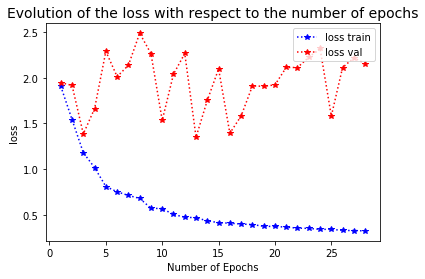

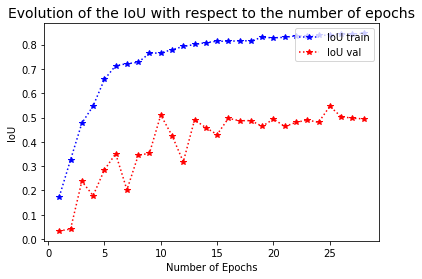

In [54]:
#history_train_loss, history_val_loss, history_train_iou, history_val_iou
plot_train_val(history_train_loss,history_val_loss,period=1, metric='loss')
plot_train_val(history_train_iou,history_val_iou,period=1, metric='IoU')

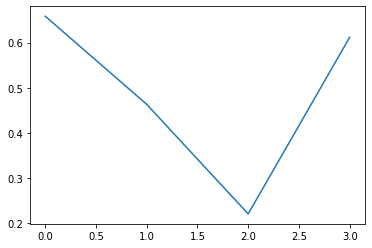

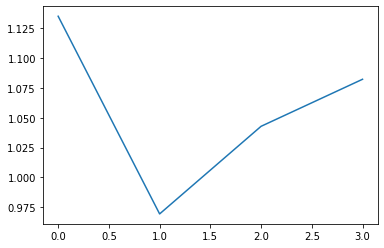

In [21]:
plt.plot(history_val_iou)
plt.show()
plt.plot(history_train_iou)

# Cross Validation

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = 0.01

iou_, acc_ = cross_validation(train_dataset=train_set,n_splits, loss_function, num_epochs, lr)

# Find Best Learning Rate

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = np.logspace(-1,-2,num=5)

best_lr, best_iou = select_hyper_param(train_dataset,n_splits,loss_function,num_epochs,lr_candidates)

# Adaptative Learning
We may do a grid search on the learning rates with cross validation to find the best learning_rate. For now the used metric is iou.

In [ ]:
lr_candidates = np.logspace(-1,-2,num=5)
num_epochs = 5
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())

best_model = UNet(3,1,False).to(device)

best_iou, history_iou = adptative_learning(train_set,val_loader,loss_function,best_model,num_epochs,lr_candidates)


In [ ]:
torch.save(best_model.state_dict(), 'model/best_model06122020.pt')

# Visualization of the model

## Display a image with its mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


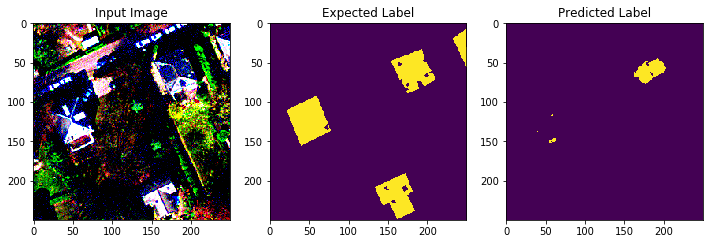

0.1243 0.918384


In [64]:
model.eval()
fig = plt.figure()
fig.set_size_inches(12, 7, forward=True)

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Expected Label')
ax3 = fig.add_subplot(1,3,3)
ax3.title.set_text('Predicted Label')

index_random_sample = int(np.random.random()*len(train_loader.dataset))
(x,y) = train_loader.dataset[index_random_sample]
ax1.imshow(np.transpose(x.numpy(),(1,2,0)))

ax2.imshow(y)

ypred = torch.squeeze(model.predict(torch.unsqueeze(x,0).cuda())).cpu().detach().numpy()

ax3.imshow(np.around(ypred))
np.around(iou(np.around(ypred),y.numpy()),4),accuracy(np.around(ypred),y.numpy())
acc = np.around(iou(np.around(ypred),y.numpy()),4)
plt.show()
print(acc,accuracy(np.around(ypred),y.numpy()))

## Display an unseen image

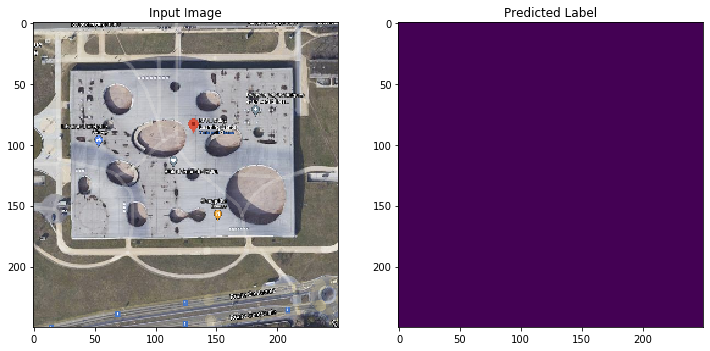

In [66]:
import_and_show(model,'test.png') # Note that 'test.png' should be located in the root of the folder

In [67]:
val = []
for i in range(2):
    print(i)
    val.append(test_model(test_loader,model))
np.mean(val)
print(val)

0
1
[[0.5884800563399316, 0.9513434838709677], [0.5884800563399316, 0.9513434838709678]]
